In [1]:
import cv2
import numpy as np
from matplotlib import cm
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
def convert_to_temperature(pixel_avg):
    """
    Converts pixel value (mean) to temperature (fahrenheit) depending upon the camera hardware
    """
    norm = pixel_avg/255
    temp = np.linspace(38,105,10000)
    cmap = cm.get_cmap('gray',10000)
    x = cmap(range(10000))
    x = x[:,0]
    difference_array = np.absolute(x-norm)
    index = difference_array.argmin()
    return  temp[index]

In [3]:
def process_frame(frame,noses):
    mean = 0
    for x,y,w,h in noses:
        cropped_image = frame[int(y):int(y+h), 
                      int(x):int(x+w)]
        nose_frame = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        heatmap_gray = cv2.cvtColor(nose_frame, cv2.COLOR_RGB2GRAY)
        heatmap = cv2.applyColorMap(heatmap_gray, cv2.COLORMAP_HOT)

        # Binary threshold
        _, binary_thresh = cv2.threshold(heatmap_gray, 135, 255,cv2.THRESH_BINARY)

        # Image opening: Erosion followed by dilation
        kernel = np.ones((3, 3), np.uint8)
        image_erosion = cv2.erode(binary_thresh, kernel, iterations=1)
        image_opening = cv2.dilate(image_erosion, kernel, iterations=1)
        mean = convert_to_temperature(cv2.mean(cropped_image,mask = cv2.bitwise_not(image_opening))[0])
    return mean
   

In [4]:
cap = cv2.VideoCapture(r'C:\Users\this pc\Documents\Imager Data\1.wmv')
frame_number = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)
ts = round(1/fps,2)
t = np.arange(0,int(frame_number/fps),ts)
nose_cascade = cv2.CascadeClassifier('cascade.xml')
amplitude = []
while True:
    success, frame = cap.read()
    if not success:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    noses = nose_cascade.detectMultiScale(gray, 1.1, 4)
    for x,y,w,h in noses:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    amplitude.append(process_frame(frame,noses))
    cv2.imshow('img',frame)
    if cv2.waitKey(int(ts*1000))& 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [5]:
amplitude = amplitude[0:np.shape(t)[0]]

In [6]:
new_amp = []
new_t = []
x = []
for i in range(len(amplitude)):
    if amplitude[i] != 0:
        new_amp.append(amplitude[i])
        new_t.append(t[i])
    else:
        x.append(t[i])
y = np.interp(x,new_t,new_amp)
j = 0
for i in range(len(amplitude)):
    if amplitude[i] == 0:
        amplitude[i] = y[j]
        j += 1
amplitude = np.array(amplitude)
amplitude = amplitude - amplitude.mean()
#new_amp = np.array(new_amp)
#new_t = np.array(new_t)
#new_amp = new_amp - new_amp.mean()

In [7]:
import matplotlib.pyplot as plt

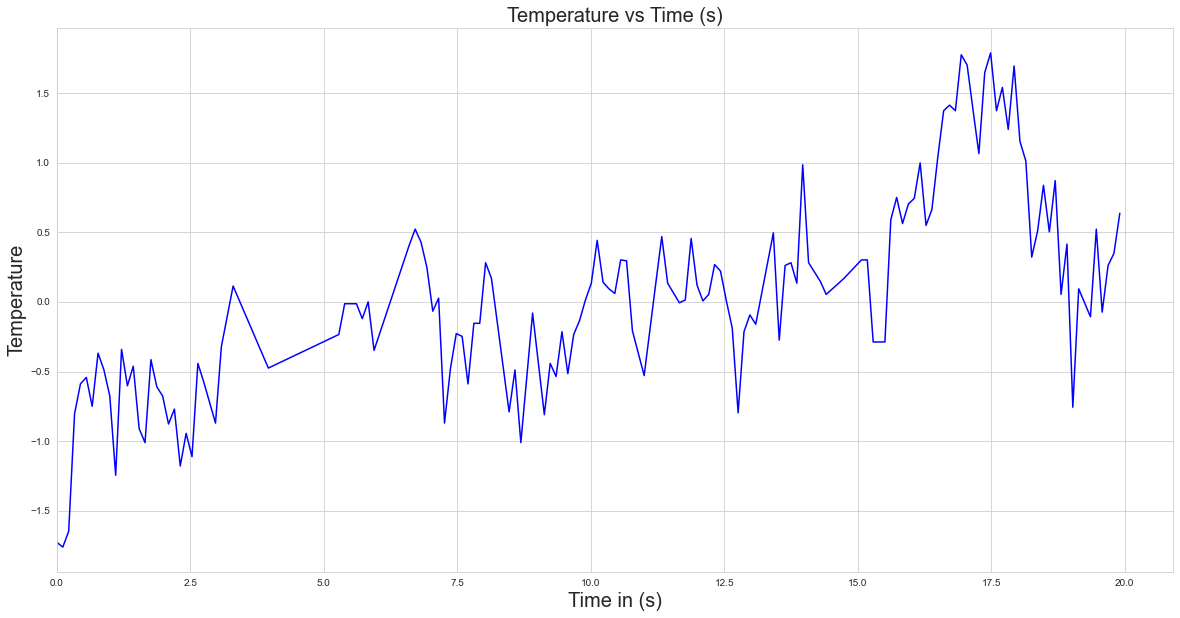

In [8]:
plt.figure(figsize = (20, 10))
plt.plot(t,amplitude,'b',label = 'Temperature vs Time')
plt.xlabel('Time in (s)',fontsize = 20)
plt.ylabel('Temperature',fontsize = 20)
plt.title('Temperature vs Time (s)',fontsize = 20)
plt.xlim(left = 0)
plt.show()

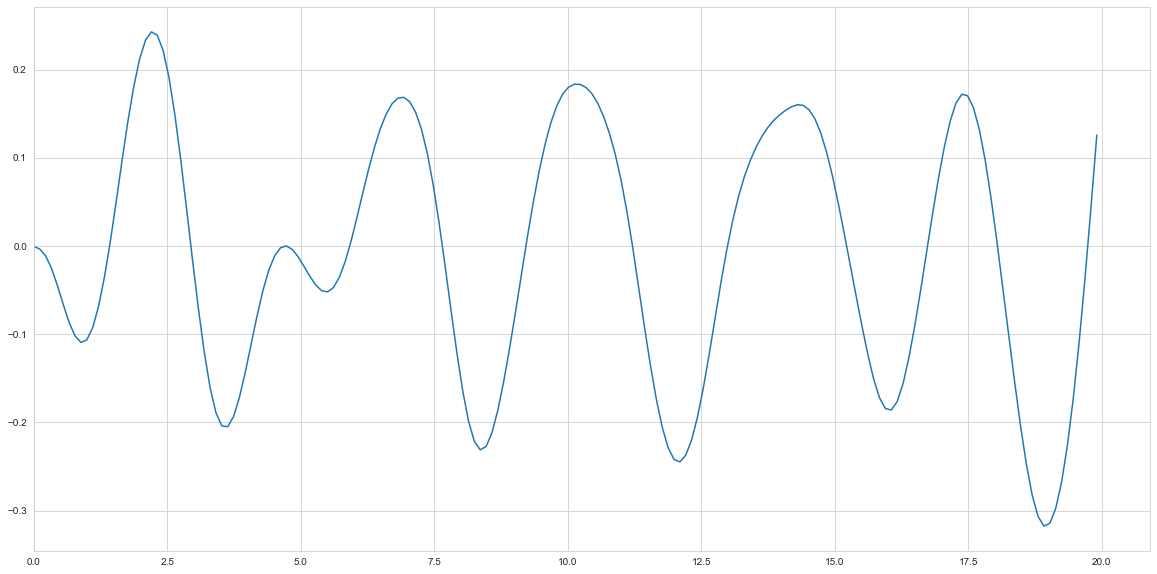

In [9]:
from scipy import signal
sos = signal.butter(3,[0.2,0.4],btype = 'bandpass',fs = fps,output ='sos')
filtered = signal.sosfilt(sos, amplitude)
plt.figure(figsize = (20, 10))
plt.plot(t,filtered)
plt.xlim(left = 0)
plt.show()

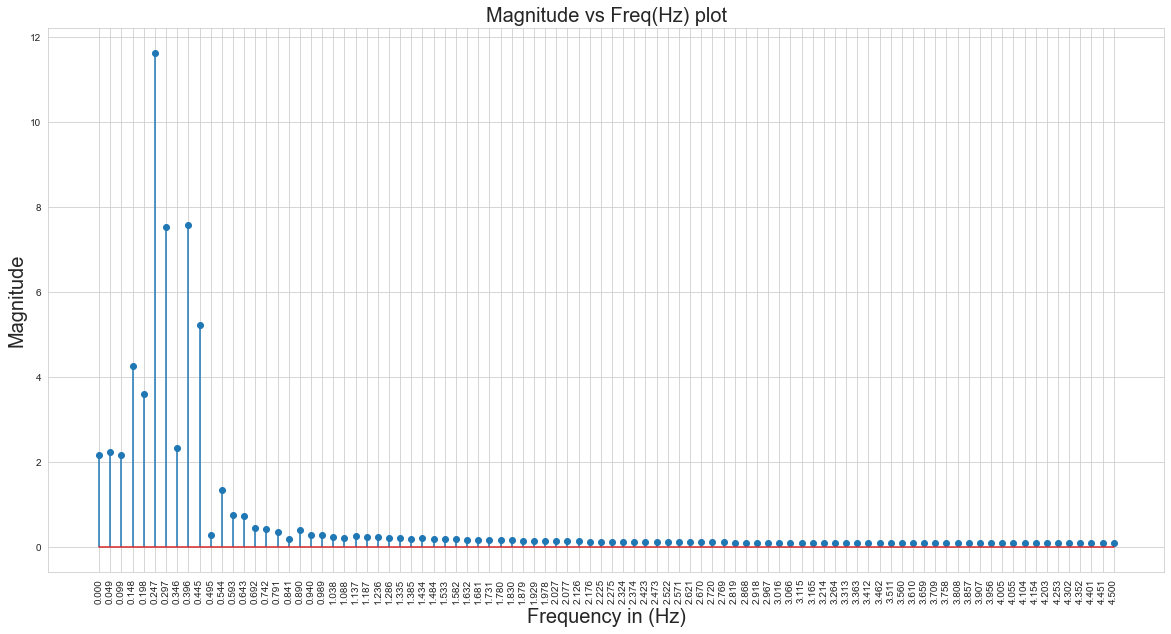

In [10]:
from scipy.fft import rfft, rfftfreq
yf = rfft(filtered)
xf = rfftfreq(len(filtered), 1 / fps)
plt.figure(figsize = (20, 10))
plt.stem(xf,np.abs(yf))
plt.xticks(xf,rotation=90)
#plt.stem(xf[(xf > 0.2) & (xf < 0.33)], np.abs(yf)[(xf > 0.2) & (xf < 0.33)])
#plt.xticks(xf[(xf > 0.2) & (xf < 0.33)],rotation = 90)
plt.xlabel('Frequency in (Hz)',fontsize = 20)
plt.ylabel('Magnitude',fontsize = 20)
plt.title('Magnitude vs Freq(Hz) plot',fontsize = 20)
plt.show()